* 6 models
    * 2 FC
    * 2 2D CNN
    * 2 3D CNN
    * Shouldn't overfit ( < 600k parameters )
* Visualize CNN kernels
    * Identify frequnecy bands that are being observed

In [170]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pywt
from scipy import signal
from tqdm import tqdm

%matplotlib inline

## Load data

In [182]:
data_path = "Data/GeneratedData/combined_data/"
base_path = os.getcwd()

# REST
# IDD = np.load(os.path.join(data_path, "IDD_rest.npy"))
# TDC = np.load(os.path.join(data_path, "TDC_rest.npy"))

# MUSIC
# IDD = np.load(os.path.join(data_path, "IDD_music.npy"))
# TDC = np.load(os.path.join(data_path, "TDC_music.npy"))

# X = np.concatenate((TDC, IDD))
X_scalogram = np.load("Data/GeneratedData/X_scalogram_music.npy")
Y = [0]*(len(X_scalogram)//2) + [1]*(len(X_scalogram)//2)
Y = np.asarray(Y)

In [183]:
print(X_scalogram.shape)
print(Y.shape)

(8470, 448, 128)
(8470,)


## Create Spectrograms

In [185]:
# Modified scalogram function from Fusion notebook
def scalogram(x, Hz, hz, num_secs, w = 5.):
    ''' x = time series
        Hz = sampling rate in Hz of the input signal
        hz = desired sampling rate (by downsampling)
        start_sec = starting second in x
        num_secs = total number of seconds of our clip
        w = width parameter
        log =raw_seiz if true take log of spectrum values
    '''
    
    downsample = int(round(Hz / hz))
    X = x[0: num_secs * Hz : downsample]


    t, dt = np.linspace(0, num_secs, hz * num_secs, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, fs / 2, int(hz / 2))
    widths = w * fs / (2 * np.pi * freq)

    cwtm = signal.cwt(X,
                      signal.morlet2,
                      widths,
                      w = w)
    
    return cwtm

In [186]:
def generate_scalogram(data, Hz, hz, num_secs, w = 5.):
    scalogram_data = np.zeros((data.shape[0], data.shape[1] * (hz // 2), hz * num_secs), dtype="complex128")
    for sample_index in tqdm(range(data.shape[0])):
        for channel_index in range(0, data.shape[1]):
            scalogram_data[sample_index][channel_index * (hz//2): channel_index * (hz//2) + hz//2] = \
            scalogram(data[sample_index][channel_index], 128, 64, 2)
    return scalogram_data

In [128]:
# X_scalogram = generate_scalogram(X, 128, 64, 2)

100%|██████████| 8470/8470 [04:45<00:00, 29.69it/s]


In [187]:
X_scalogram.shape

(8470, 448, 128)

In [130]:
# np.save("Data/GeneratedData/X_scalogram_music", X_scalogram)

In [188]:
def plot_scalogram(data, labels, sample_index, channel, N=128, hz=64, T=2, ts=0, w=4.):
    """
    :param N: signal sampling rate
    :param hz: downsampled sampling rate
    :param T: seconds
    :param ts: starting second
    :param w: 
    """

    t, dt = np.linspace(ts, ts + T, hz * T, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, (fs / 2), int(hz / 2))
    
    print("Y label:", labels[sample_index])
    
    plt.rcParams['figure.figsize'] = 12, 4
    x = np.arange(N)
    im = plt.pcolormesh(x, freq, np.abs(np.squeeze(data[sample_index][channel])), cmap = 'jet') # 'viridis'
#     plt.title("Scalogram for channel 4 of a TDC subject at rest")
    plt.show()


In [189]:
plot_scalogram(X_scalogram_shaped, Y, 2000, 4)

Y label: 0


IndexError: index 2000 is out of bounds for axis 0 with size 14

In [190]:
# reshape data
X_scalogram_shaped = X_scalogram.reshape(14, X_scalogram.shape[0]//14, 14, 32, 128, 1)
Y_shaped = Y.reshape(14, Y.shape[0]//14)
print("X_scalogram shape: ", X_scalogram_shaped.shape)
print("Y shape", Y_shaped.shape)

X_scalogram shape:  (14, 605, 14, 32, 128, 1)
Y shape (14, 605)


## KFold Cross Validation

In [179]:
def generate_splits():
    # [0, 1, 2, 3,  4,  5,  6]
    # [7, 8, 9, 10, 11, 12, 13]
    train_indices = [[2,3,4,5,6,9,10,11,12,13], [0,1,4,5,6,7,8,11,12,13], [0,1,2,3,6,7,8,9,10,13]]
    val_indices = [[0,1,7,8], [2,3,9,10], [4,5,11,12]]
    
    for ti, vi in zip(train_indices, val_indices):
        yield ti, vi
        
# for t, v in generate_splits():
#     print(t, v)

## Rest Model

In [181]:
fold_count = 1
acc_per_fold = []
loss_per_fold = []

for train_indices, val_indices in generate_splits():
    print('-------------------------------------------------------------------------------------------')
    
    # Define model
    cnn_3d = keras.Sequential([
        # Set input layer
        keras.layers.InputLayer(input_shape=input_shape),

        # Conv + Maxpooling
        keras.layers.Conv3D(4, (5, 5, 5), padding="same", activation=tf.nn.relu),
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),

        keras.layers.Conv3D(4, (5, 5, 5), padding="same", activation=tf.nn.relu),
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),

        # Normalization
        keras.layers.BatchNormalization(),

        # Flatten to 1D
        keras.layers.Flatten(),

        keras.layers.Dense(8, activation=tf.nn.relu),

        keras.layers.Dropout(0.4),

        keras.layers.Dense(4, activation=tf.nn.relu),


        # Sigmoid
        keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    
    # Compile Model
    cnn_3d.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy'],
    )
#     cnn_3d.summary()
    
    print(f'Training for fold {fold_count} ...')
    # Train model
    history = cnn_3d.fit(X_scalogram_shaped[train_indices].reshape((-1, 14, 32, 128, 1)),
                    Y_shaped[train_indices].reshape(-1), 
                    epochs=10, 
                    batch_size=256,
                    verbose=1)
    
    # Generate generalization metrics
    scores = cnn_3d.evaluate(X_scalogram_shaped[val_indices].reshape((-1, 14, 32, 128, 1)),
                             Y_shaped[val_indices].reshape(-1), 
                             verbose=0)
    print(f'Score for fold {fold_count}: {cnn_3d.metrics_names[0]} of {scores[0]}; {cnn_3d.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_count += 1
    tf.keras.backend.clear_session()
    
# summary
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

-------------------------------------------------------------------------------------------
Training for fold 1 ...
Train on 6050 samples
Epoch 1/10
6050/6050 [==============================] - 253s 42ms/sample - loss: 0.5252 - accuracy: 0.7410
Epoch 2/10
6050/6050 [==============================] - 208s 34ms/sample - loss: 0.1757 - accuracy: 0.8855
Epoch 3/10
6050/6050 [==============================] - 208s 34ms/sample - loss: 0.0794 - accuracy: 0.9825
Epoch 4/10
6050/6050 [==============================] - 210s 35ms/sample - loss: 0.0640 - accuracy: 0.9931
Epoch 5/10
6050/6050 [==============================] - 210s 35ms/sample - loss: 0.0539 - accuracy: 0.9942
Epoch 6/10
6050/6050 [==============================] - 208s 34ms/sample - loss: 0.0560 - accuracy: 0.9940
Epoch 7/10
6050/6050 [==============================] - 208s 34ms/sample - loss: 0.0525 - accuracy: 0.9954
Epoch 8/10
6050/6050 [==============================] - 209s 35ms/sample - loss: 0.0509 - accuracy: 0.9957
Epoch 

## Music Model

In [191]:
fold_count = 1
acc_per_fold = []
loss_per_fold = []

for train_indices, val_indices in generate_splits():
    print('-------------------------------------------------------------------------------------------')
    
    # Define model
    cnn_3d = keras.Sequential([
        # Set input layer
        keras.layers.InputLayer(input_shape=input_shape),

        # Conv + Maxpooling
        keras.layers.Conv3D(6, (3, 3, 3), padding="same", activation=tf.nn.relu),
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),

        keras.layers.Conv3D(6, (3, 3, 3), padding="same", activation=tf.nn.relu),
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),

        # Normalization
        keras.layers.BatchNormalization(),

        # Flatten to 1D
        keras.layers.Flatten(),

        keras.layers.Dense(16, activation=tf.nn.relu),

        keras.layers.Dropout(0.5),

        keras.layers.Dense(8, activation=tf.nn.relu),


        # Sigmoid
        keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    
    # Compile Model
    cnn_3d.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy'],
    )
#     cnn_3d.summary()
    
    print(f'Training for fold {fold_count} ...')
    # Train model
    history = cnn_3d.fit(X_scalogram_shaped[train_indices].reshape((-1, 14, 32, 128, 1)),
                    Y_shaped[train_indices].reshape(-1), 
                    epochs=10, 
                    batch_size=256,
                    verbose=1)
    
    # Generate generalization metrics
    scores = cnn_3d.evaluate(X_scalogram_shaped[val_indices].reshape((-1, 14, 32, 128, 1)),
                             Y_shaped[val_indices].reshape(-1), 
                             verbose=0)
    print(f'Score for fold {fold_count}: {cnn_3d.metrics_names[0]} of {scores[0]}; {cnn_3d.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_count += 1
    tf.keras.backend.clear_session()
    
# summary
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

-------------------------------------------------------------------------------------------
Training for fold 1 ...
Train on 6050 samples
Epoch 1/10
6050/6050 [==============================] - 192s 32ms/sample - loss: 0.2551 - accuracy: 0.8783
Epoch 2/10
6050/6050 [==============================] - 136s 22ms/sample - loss: 0.0470 - accuracy: 0.9780
Epoch 3/10
6050/6050 [==============================] - 135s 22ms/sample - loss: 0.0255 - accuracy: 0.9860
Epoch 4/10
6050/6050 [==============================] - 136s 22ms/sample - loss: 0.0222 - accuracy: 0.9843
Epoch 5/10
6050/6050 [==============================] - 136s 22ms/sample - loss: 0.0192 - accuracy: 0.9846
Epoch 6/10
6050/6050 [==============================] - 136s 23ms/sample - loss: 0.0194 - accuracy: 0.9850
Epoch 7/10
6050/6050 [==============================] - 136s 22ms/sample - loss: 0.0179 - accuracy: 0.9936
Epoch 8/10
6050/6050 [==============================] - 138s 23ms/sample - loss: 0.0167 - accuracy: 0.9932
Epoch 

## Rest
> Fold 1 - Loss: 0.002286005566025583 - Accuracy: 99.95867609977722%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.090741858406862 - Accuracy: 96.65289521217346%
------------------------------------------------------------------------
> Fold 3 - Loss: 5.9722688476245735e-05 - Accuracy: 100.0%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 98.87052377065022 (+- 1.5681909394184559)
> Loss: 0.03102919555378794
------------------------------------------------------------------------

## Music
> Fold 1 - Loss: 4.083900158688668e-05 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.0019158795303742071 - Accuracy: 99.91735816001892%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.01989371296079947 - Accuracy: 99.62809681892395%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 99.84848499298096 (+- 0.15944827557759023)
> Loss: 0.0072834771642535205
------------------------------------------------------------------------

## Test-Train split

In [134]:
# X_train, X_val, y_train, y_val = train_test_split(X_scalogram_shaped, Y, test_size=0.2, stratify=Y, random_state=42)

In [10]:
# 12/2 split
# X_train = np.concatenate((X_scalogram_shaped[:3630], X_scalogram_shaped[4235:7865]))
# y_train = np.concatenate((Y[:3630], Y[4235:7865]))

# X_val = np.concatenate((X_scalogram_shaped[3630:4235], X_scalogram_shaped[7865:]))
# y_val = np.concatenate((Y[3630:4235], Y[7865:]))


# 10/4 split
X_train = np.concatenate((X_scalogram_shaped[:3025], X_scalogram_shaped[4235:7260]))
y_train = np.concatenate((Y[:3025], Y[4235:7260]))

X_val = np.concatenate((X_scalogram_shaped[3025:4235], X_scalogram_shaped[7260:]))
y_val = np.concatenate((Y[3025:4235], Y[7260:]))

# shuffle data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)

In [11]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
input_shape = X_train.shape[1:]
print("input_shape: ", input_shape)

X_train shape: (6050, 14, 32, 128, 1)
y_train shape: (6050,)
X_val shape: (2420, 14, 32, 128, 1)
y_val shape: (2420,)
input_shape:  (14, 32, 128, 1)


## Model

In [17]:
def plot_history(history):
    # Retrieve a list of accuracy results on training and test data
    # sets for each training epoch
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Retrieve a list of list results on training and test data
    # sets for each training epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))
    plt.figure(figsize=(6.4,4.8))
    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.legend(['train', 'val'], loc='upper left')

    plt.figure(figsize=(6.4,4.8))

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.legend(['train', 'val'], loc='upper left')

In [20]:
# REST
# cnn_3d = keras.Sequential([
#     # Set input layer
#     keras.layers.InputLayer(input_shape=input_shape),
    
#     # Conv + Maxpooling
#     keras.layers.Conv3D(4, (5, 5, 5), padding="same", activation=tf.nn.relu),
#     keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    
#     keras.layers.Conv3D(4, (5, 5, 5), padding="same", activation=tf.nn.relu),
#     keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    
#     # Normalization
#     keras.layers.BatchNormalization(),
    
#     # Flatten to 1D
#     keras.layers.Flatten(),
    
#     keras.layers.Dense(8, activation=tf.nn.relu),
    
#     keras.layers.Dropout(0.4),
    
#     keras.layers.Dense(4, activation=tf.nn.relu),
    
    
#     # Sigmoid
#     keras.layers.Dense(1, activation=tf.nn.sigmoid)
# ])


In [18]:
# MUSIC
cnn_3d = keras.Sequential([
    # Set input layer
    keras.layers.InputLayer(input_shape=input_shape),
    
    # Conv + Maxpooling
    keras.layers.Conv3D(6, (3, 3, 3), padding="same", activation=tf.nn.relu),
    keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    
    keras.layers.Conv3D(6, (3, 3, 3), padding="same", activation=tf.nn.relu),
    keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    
    # Normalization
    keras.layers.BatchNormalization(),
    
    # Flatten to 1D
    keras.layers.Flatten(),
    
    keras.layers.Dense(16, activation=tf.nn.relu),
    
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(8, activation=tf.nn.relu),
    
    
    # Sigmoid
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])


In [19]:
cnn_3d.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
cnn_3d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_2 (Conv3D)            (None, 14, 32, 128, 6)    168       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 16, 64, 6)      0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 16, 64, 6)      978       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 3, 8, 32, 6)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 8, 32, 6)       24        
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)               

Train on 6050 samples, validate on 2420 samples
Epoch 1/15
6050/6050 [==============================] - 188s 31ms/sample - loss: 0.3731 - accuracy: 0.8180 - val_loss: 0.2231 - val_accuracy: 0.8971
Epoch 2/15
6050/6050 [==============================] - 174s 29ms/sample - loss: 0.0889 - accuracy: 0.9536 - val_loss: 0.0877 - val_accuracy: 0.9616
Epoch 3/15
6050/6050 [==============================] - 169s 28ms/sample - loss: 0.0506 - accuracy: 0.9673 - val_loss: 0.0917 - val_accuracy: 0.9599
Epoch 4/15
6050/6050 [==============================] - 179s 30ms/sample - loss: 0.0387 - accuracy: 0.9660 - val_loss: 0.0690 - val_accuracy: 0.9731
Epoch 5/15
6050/6050 [==============================] - 169s 28ms/sample - loss: 0.0279 - accuracy: 0.9684 - val_loss: 0.0655 - val_accuracy: 0.9744
Epoch 6/15
6050/6050 [==============================] - 179s 30ms/sample - loss: 0.0247 - accuracy: 0.9770 - val_loss: 0.0367 - val_accuracy: 0.9839
Epoch 7/15
6050/6050 [==============================] - 17

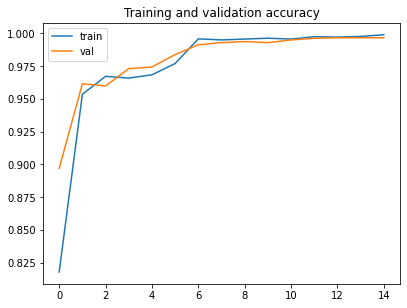

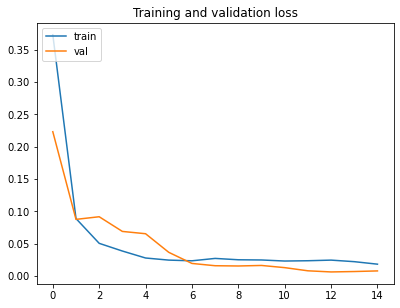

In [20]:
plot_history(cnn_3d.fit(X_train, 
                    y_train, 
                    epochs=15, 
                    batch_size=256,
                    validation_data=(X_val, y_val), 
                    verbose=1))

In [109]:
cnn_3d.save("models/cnn_3d")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/cnn_3d/assets


* Rest
    * Validation accuracy: 100%
    * Validation loss: 9.6468e-04


---

* Rest
    * Validation accuracy: 100%
    * Validation loss: 0.0011
* Music
    * Validation accuracy: 100%
    * Validation loss: 4.7472e-5


## Visualize Layers

In [21]:
from tensorflow.keras.models import Model
layer_outputs = [layer.output for layer in cnn_3d.layers]
for layer in layer_outputs:
    print(layer)
# feature_map_model = Model(inputs=complex_model.input, output=layer_outputs)
feature_map_model = Model(cnn_3d.input, layer_outputs)

Tensor("conv3d_2/Identity:0", shape=(None, 14, 32, 128, 6), dtype=float32)
Tensor("max_pooling3d_2/Identity:0", shape=(None, 7, 16, 64, 6), dtype=float32)
Tensor("conv3d_3/Identity:0", shape=(None, 7, 16, 64, 6), dtype=float32)
Tensor("max_pooling3d_3/Identity:0", shape=(None, 3, 8, 32, 6), dtype=float32)
Tensor("batch_normalization_1/Identity:0", shape=(None, 3, 8, 32, 6), dtype=float32)
Tensor("flatten_1/Identity:0", shape=(None, 4608), dtype=float32)
Tensor("dense_3/Identity:0", shape=(None, 16), dtype=float32)
Tensor("dropout_1/Identity:0", shape=(None, 16), dtype=float32)
Tensor("dense_4/Identity:0", shape=(None, 8), dtype=float32)
Tensor("dense_5/Identity:0", shape=(None, 1), dtype=float32)


In [34]:
# def display_activation(activations, col_size, row_size, layer, act_index): 
#     activation = activations[layer][0][act_index]
#     activation_index=0
#     fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*8,col_size*8))
#     for row in range(0,row_size):
#         for col in range(0,col_size):
#             ax[row][col].imshow(activation[0, :, :, activation_index], cmap='jet')
#             activation_index += 1

In [131]:
def display_activation(activations, col_size, row_size, layer, filter_num): 
    activation = activations[layer][0][:][:][:][filter_num]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*8,col_size*5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[:, :, activation_index], cmap='jet')
            activation_index += 1
            ax[row][col].invert_yaxis()

In [64]:
# activations = feature_map_model.predict(X_train[index].reshape(1,14,32,128,1))
# len(activations[0][0][0][0][0])
# shape: (10, 1, 14, 32, 128, 6)

6

Channel 0
Y label: 1


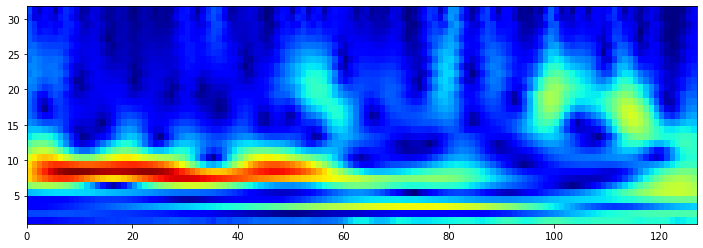

Channel 1
Y label: 1


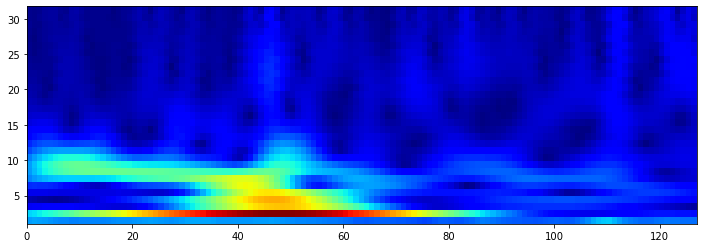

Channel 2
Y label: 1


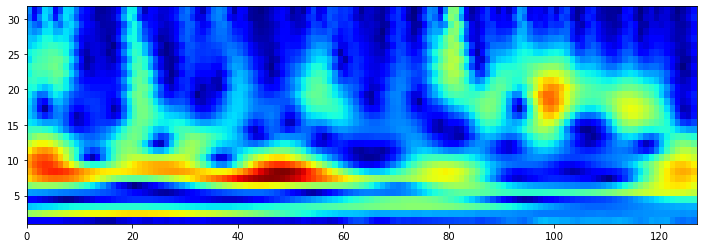

Channel 3
Y label: 1


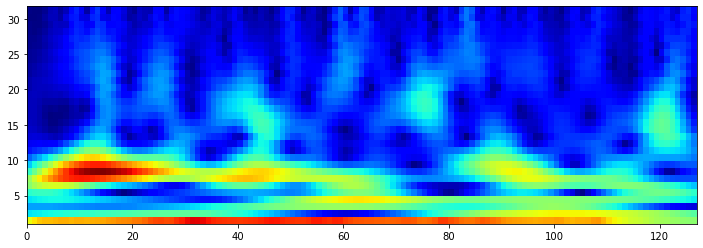

Channel 4
Y label: 1


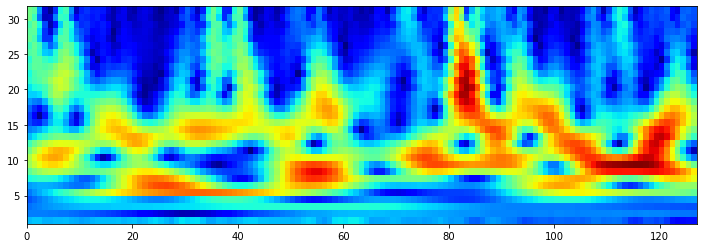

Channel 5
Y label: 1


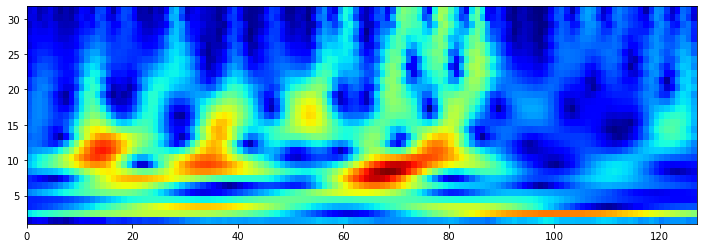

Channel 6
Y label: 1


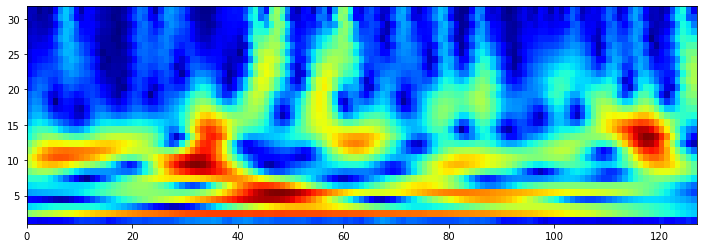

Channel 7
Y label: 1


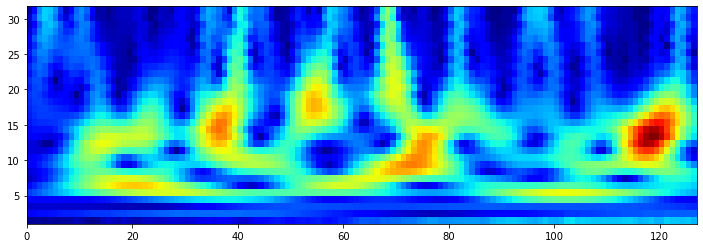

Channel 8
Y label: 1


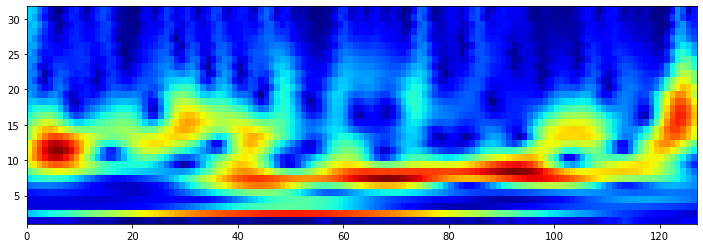

Channel 9
Y label: 1


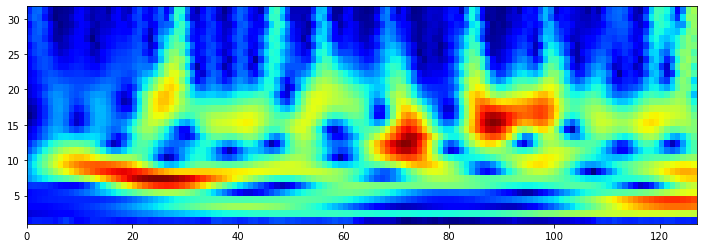

Channel 10
Y label: 1


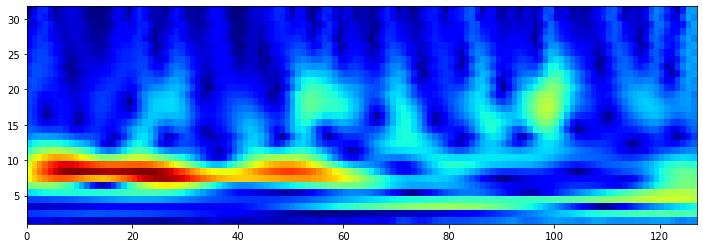

Channel 11
Y label: 1


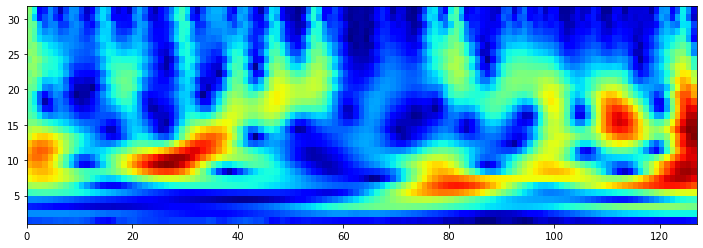

Channel 12
Y label: 1


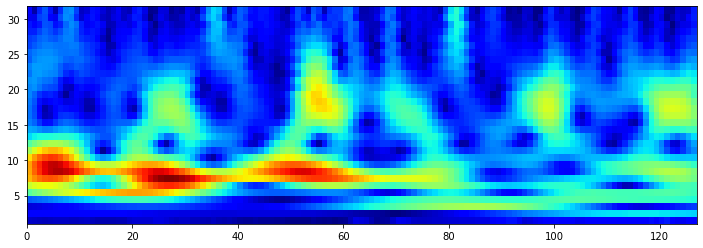

Channel 13
Y label: 1


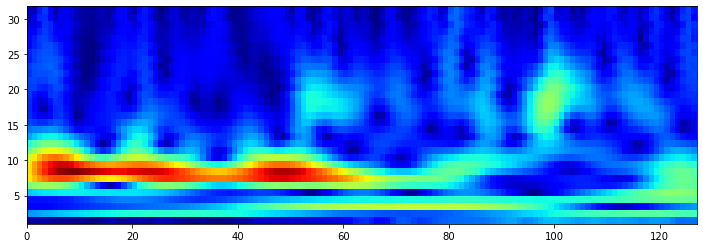

In [167]:
tdc_index = 100

for i in range(14):
    print("Channel", i)
    plot_scalogram(X_train.reshape(X_train.shape[0], 14, 32, 128), y_train, tdc_index, i)


Channel 0
Y label: 1


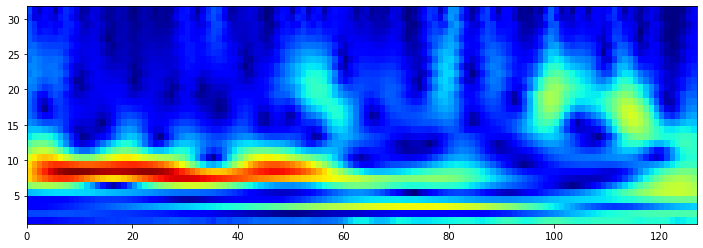

In [168]:
channel = 0
print("Channel", channel)
plot_scalogram(X_train.reshape(X_train.shape[0], 14, 32, 128), y_train, tdc_index, channel)

Label:  1
Prediction: 1.0


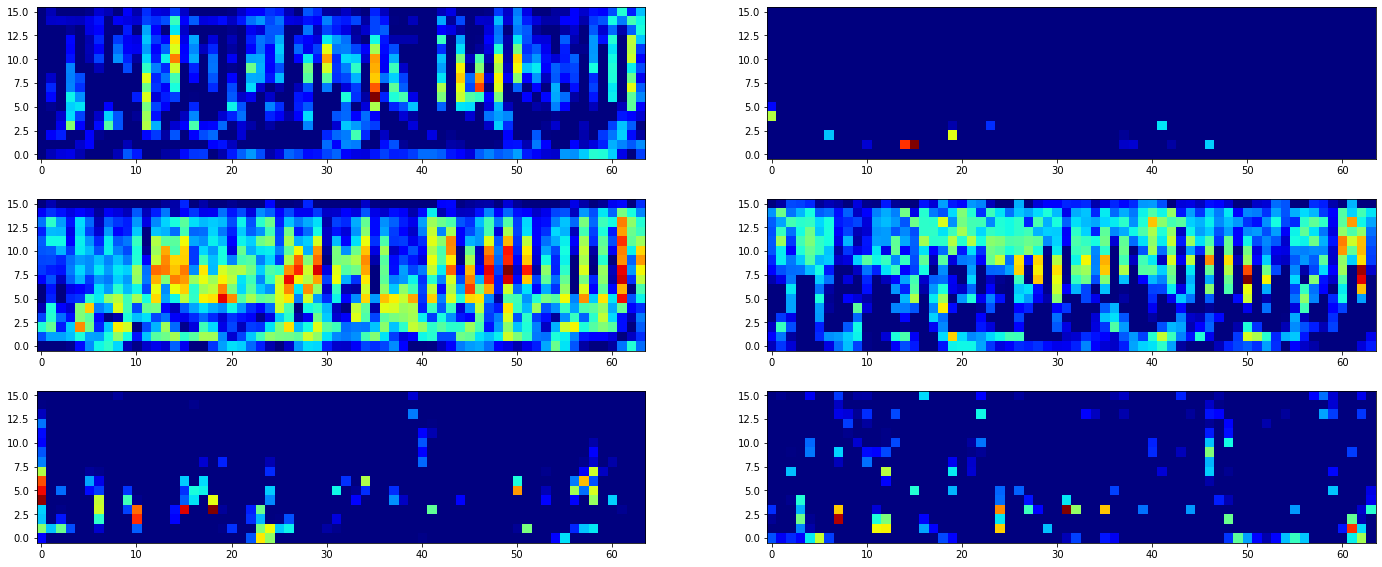

In [169]:
filter_num = 3
layer = 2

activations = feature_map_model.predict(X_train[tdc_index].reshape(1,14,32,128,1))
display_activation(activations, 2, 3, layer, filter_num)
print("Label: ", y_train[tdc_index])
print("Prediction:", activations[9][0][0])

Channel 0
Y label: 0


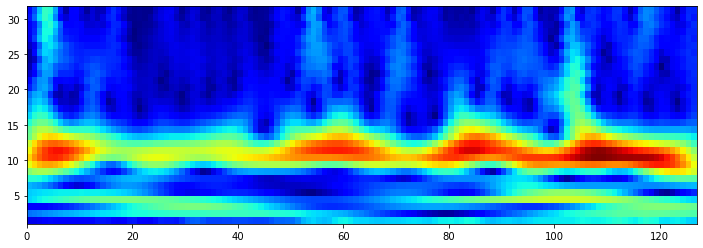

Channel 1
Y label: 0


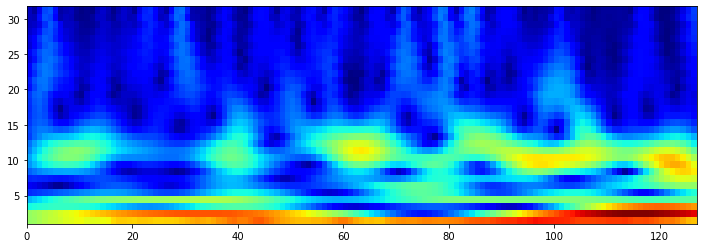

Channel 2
Y label: 0


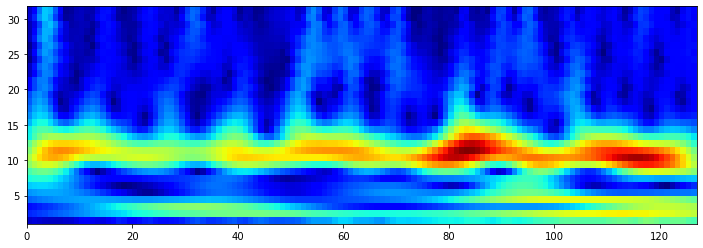

Channel 3
Y label: 0


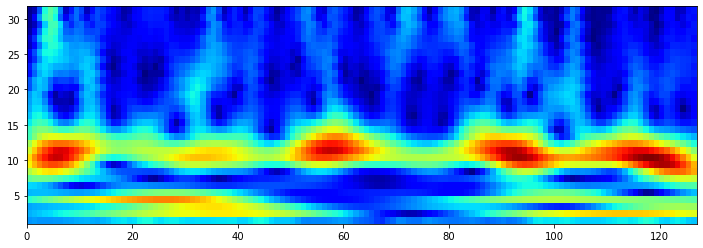

Channel 4
Y label: 0


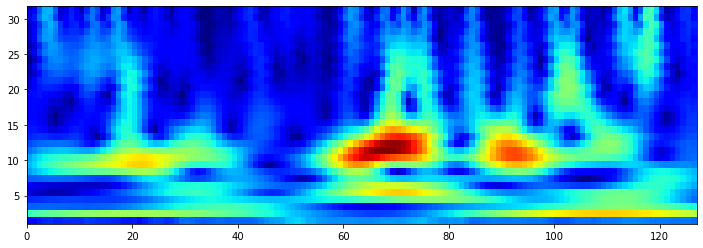

Channel 5
Y label: 0


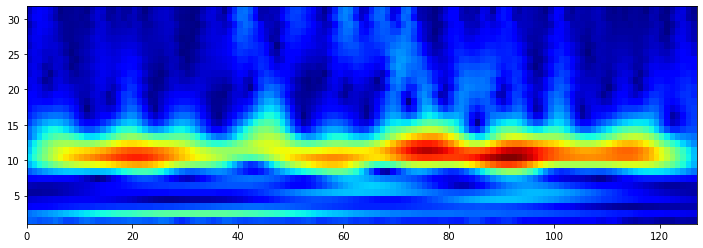

Channel 6
Y label: 0


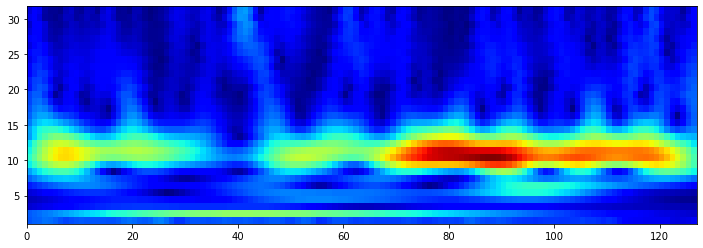

Channel 7
Y label: 0


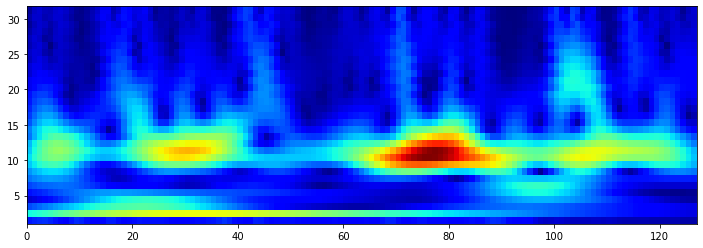

Channel 8
Y label: 0


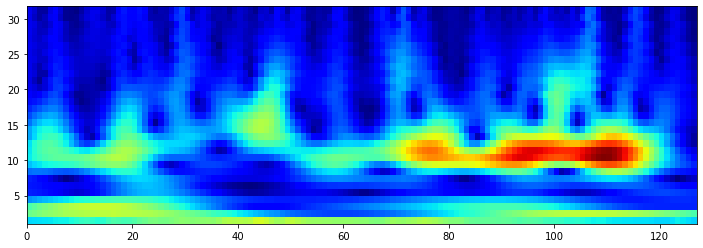

Channel 9
Y label: 0


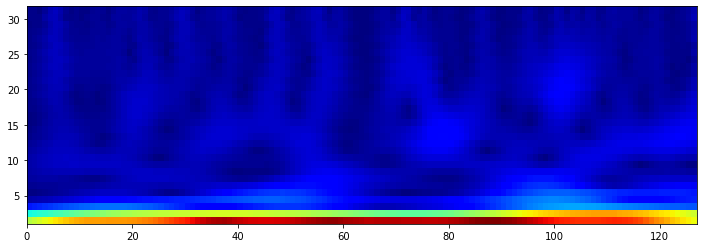

Channel 10
Y label: 0


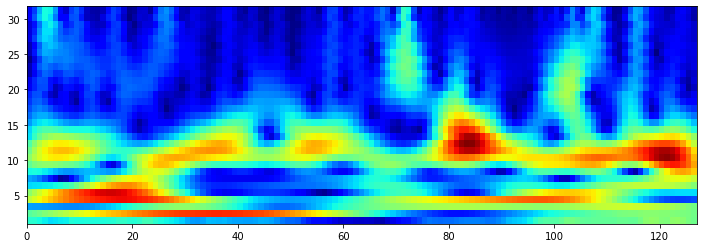

Channel 11
Y label: 0


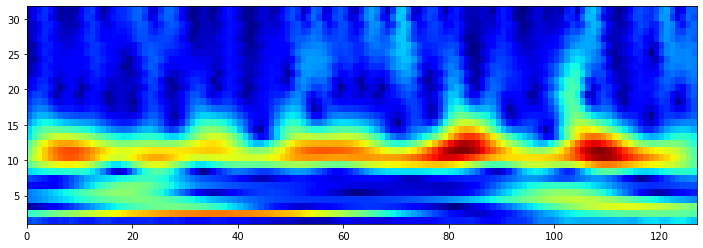

Channel 12
Y label: 0


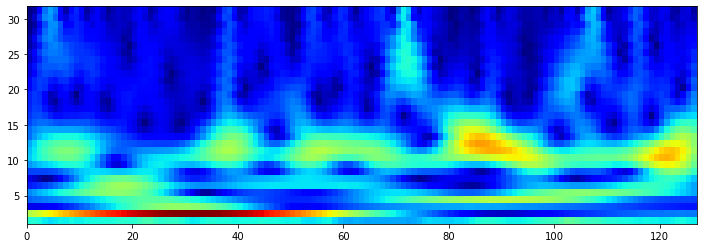

Channel 13
Y label: 0


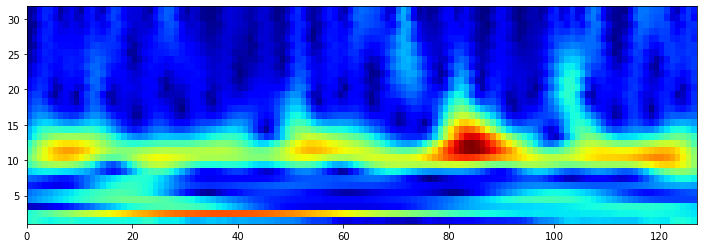

In [164]:
index = 200

for i in range(14):
    print("Channel", i)
    plot_scalogram(X_train.reshape(X_train.shape[0], 14, 32, 128), y_train, index, i)


Channel 8
Y label: 0


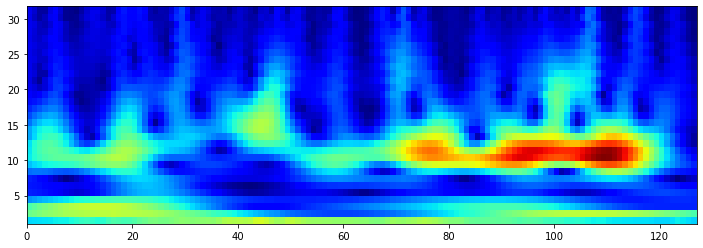

In [165]:
channel = 8
print("Channel", channel)
plot_scalogram(X_train.reshape(X_train.shape[0], 14, 32, 128), y_train, index, channel)

Label:  0
Prediction: 7.6339074e-07


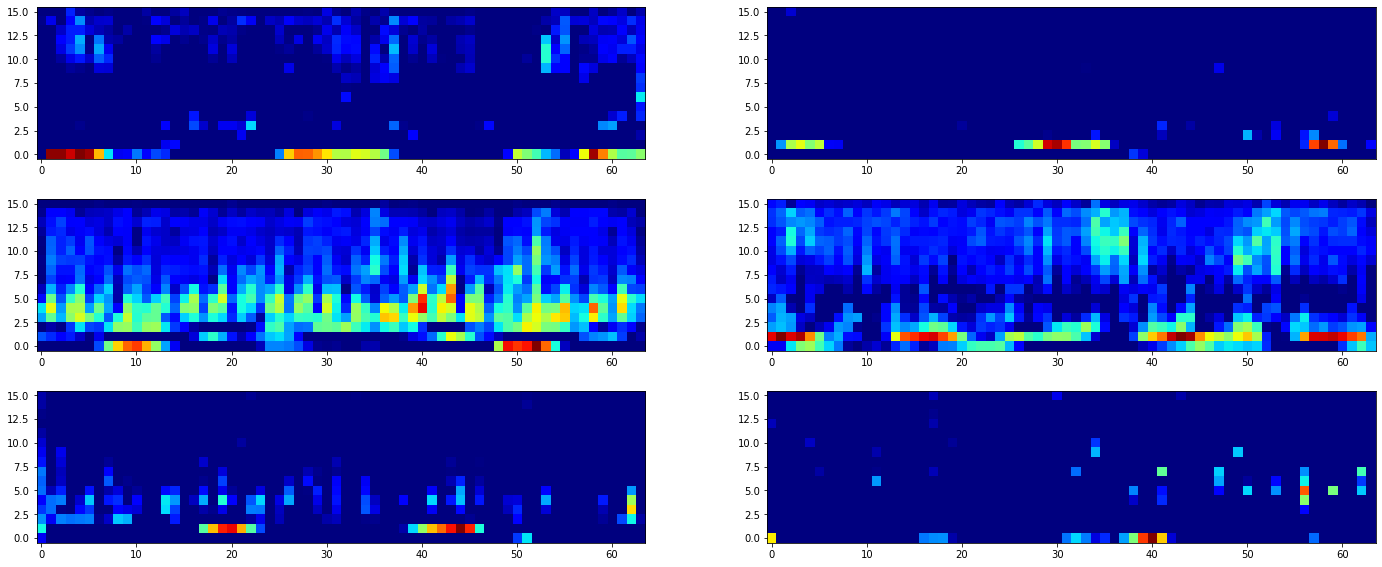

In [166]:
filter_num = 5
layer = 2

activations = feature_map_model.predict(X_train[index].reshape(1,14,32,128,1))
display_activation(activations, 2, 3, layer, filter_num)
print("Label: ", y_train[index])
print("Prediction:", activations[9][0][0])

In [95]:
activations = feature_map_model.predict(X_train[index].reshape(1,14,32,128,1))
len(activations[6][0])

16